In [1]:
import sys  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib as mpl

sys.path.insert(0, '../../')
from statlearn.regression import LinearResgression

%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
rcParams = {
    'font.family' : 'Latin Modern Math',
    'font.size': 12,
    'axes.linewidth' : 1.5,
    'mathtext.fontset' : 'stix'
}
mpl.rcParams.update(rcParams)

## Ridge Regression

Ridge regression aims to minimise the residual sum of squares with a quadratic (L2) penalty on the size of the coefficients of $\beta$:

$$\argmin_\beta \left\{(\mathbf{y} - \mathbf{X}^T\beta)^T(\mathbf{y} - \mathbf{X}^T\beta) + \lambda \beta^T\beta \right\}$$

Therefore, a closed form solution for ridge regression is given by:

$$\hat{\beta}^{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

In [2]:
data = pd.read_csv('../../data/prostate.csv', delimiter='\t', index_col=0)
data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


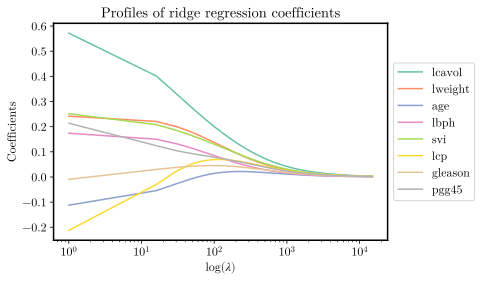

In [3]:
X = data[data.train == 'T'].drop(['lpsa', 'train'], axis=1).values
X = (X - X.mean(axis=0)) / X.std(axis=0)
y =  data[data.train == 'T']['lpsa'].values
y = (y - np.mean(y)) / np.std(y)

# compute the coefficients for a range of penalty values
penalty = np.linspace(1, 15e3, 1000)
betas_df = pd.DataFrame(
    columns=['penalty'] + list(data.drop(['lpsa', 'train'], axis=1).columns),
    index = np.arange(0, len(penalty))
)
for i, C in enumerate(penalty):
    ridge = LinearResgression(penalty='L2', C=C)
    ridge.fit(X, y, add_intercept=True)
    beta = ridge.beta
    betas_df.loc[i, 'penalty'] = C
    betas_df.iloc[i, 1:9] = beta[1:]
    
# plot the results
fig, ax = plt.subplots()
betas_df.set_index('penalty').plot(ax=ax, cmap='Set2')
ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Coefficients')
ax.set_xlabel('log($\lambda$)')
ax.set_title("Profiles of ridge regression coefficients")
plt.show()

We can use the singular value decomposition, to gain more insight into how the ridge regression works. Wirting
$$\mathbf{X} = \mathbf{U}\mathbf{D}\mathbf{V}^T$$
The ridge regression solution is seen to be:
$$
\begin{align}
\mathbf{X}\hat{\beta}^{\text{ridge}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y} \\
 &= \mathbf{UD}(\mathbf{D}^2 + \lambda\mathbf{I})^{-1}\mathbf{DU}^T\mathbf{y} \\
 & = \sum_{j=1}^{p}\mathbf{u}_j\frac{d_j^2}{d_j^2 + \lambda}\mathbf{u}_j^T\mathbf{y}
\end{align}
$$

Like linear regression, ridge regression computes the coordinates of $\mathbf{y}$ with respect to an orthonormal basis $\mathbf{U}$. It then shrinks these coordinates by the factors $\frac{d_j^2}{d_j^2 + \lambda}$.  small singular values $d_j$ correspond to directions in the column space of $\mathbf{X}$ having small variance; ridge regression shrinks these directions the most.

We can also define:
$$\text{df}(\lambda) = \sum_{j=1}^{p}\frac{d_j^2}{d_j^2 + \lambda}$$
as the *effective degrees of freedom*.

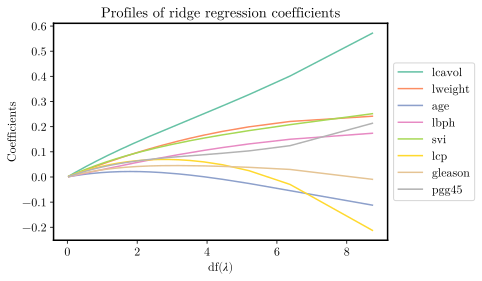

In [4]:
_, D, _ = np.linalg.svd(ridge.train_X)
def get_effective_df(D, penalty):
    return (D ** 2/ (D**2 + penalty)).sum()

betas_df['effective_df'] = [get_effective_df(D, c) for c in penalty]

fig, ax = plt.subplots()
betas_df.set_index('effective_df').drop('penalty', axis=1).plot(
    ax=ax, cmap='Set2'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Coefficients')
ax.set_xlabel('df($\lambda$)')
ax.set_title("Profiles of ridge regression coefficients")
plt.show()